In [ ]:
# generate z_1, ..., z_n ~ N(0.5, 1) with n = 200
mu = 0.5
sigma = 1
nsim = 200
set.seed(2024)
Z = rnorm(nsim, mu, sigma)

In [ ]:
# YOUR CODE (~3 lines):
# partition Z into 49 evenly spaced bins [-4.9, -4.7], [-4.7, -4.5], ..., [4.7, 4.9];
# construct a data frame with X being the centers of the above bins,
# and Y being the histogram counts of Z in each bin

num_bins = 49
hist_Z = hist(Z, breaks = seq(-4.9, 4.9, length.out = num_bins + 1), plot = FALSE)
hist_data = data.frame(X = (hist_Z$breaks[-1] + hist_Z$breaks[-num_bins]) / 2, Y = hist_Z$counts)

X = hist_data$X
Y = hist_data$Y

In [ ]:
# YOUR CODE (~1 line):
# apply Lindsey's method to fit a Poisson GLM with a degree-5 polynomial of X
# note 1: remember to add the "offset" term (correp. to h(X_i) = exp(-X_i^2/2)) to the GLM
# note 2: remember to set "raw = TRUE" if you use the poly() function;
# otherwise you arrive at orthogonal polynomials

model_full = glm(Y ~ poly(X, degree = 5, raw = TRUE) + offset(-X^2/2), family = poisson)
summary(model_full)


Call:
glm(formula = Y ~ poly(X, degree = 5, raw = TRUE) + offset(-X^2/2), 
    family = poisson)

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       2.552803   0.105176  24.272  < 2e-16 ***
poly(X, degree = 5, raw = TRUE)1  0.535521   0.156652   3.419  0.00063 ***
poly(X, degree = 5, raw = TRUE)2  0.106866   0.100005   1.069  0.28525    
poly(X, degree = 5, raw = TRUE)3 -0.008562   0.070526  -0.121  0.90337    
poly(X, degree = 5, raw = TRUE)4 -0.007268   0.013452  -0.540  0.58900    
poly(X, degree = 5, raw = TRUE)5 -0.002270   0.005942  -0.382  0.70251    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 85.967  on 48  degrees of freedom
Residual deviance: 29.579  on 43  degrees of freedom
AIC: 132.52

Number of Fisher Scoring iterations: 7


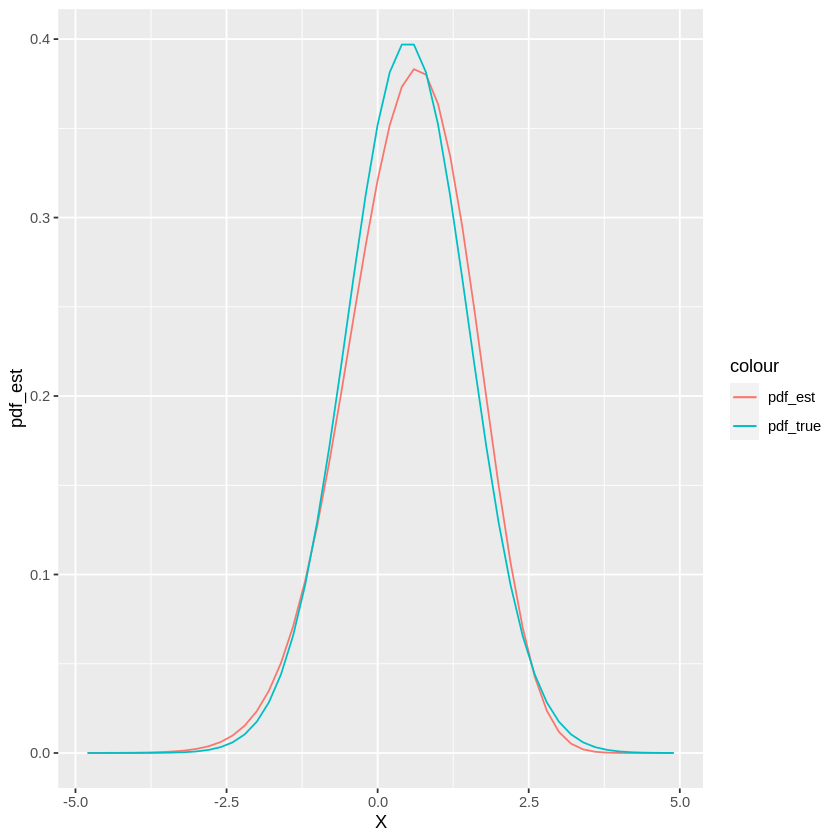

In [ ]:
library("ggplot2")

# YOUR CODE (~8 lines): use ggplot, compute and plot
# 1. the estimated pdf of Z from the above Poisson GLM
# 2. the truth pdf of Z (i.e. N(0.5, 1))
# be sure to find the right normalization for the estimated pdf
# plot them in the same figure, with different colors

pdf_est = predict(model_full, newdata = data.frame(X = X), type = "response")
total_area = sum(pdf_est * (X[2] - X[1]))
normalized_pdf_est = pdf_est / total_area

pdf_true = function(x) {
  dnorm(x, mu, sigma)
}
plot_data = data.frame(X = X, pdf_est = normalized_pdf_est, pdf_true = pdf_true(X))

ggplot(plot_data, aes(x = X)) +
  geom_line(aes(y = pdf_est, color = "pdf_est")) +
  geom_line(aes(y = pdf_true, color = "pdf_true"))

In [ ]:
AIC = c(0,0,0,0,0)

for (degree in 1 : 5) {
  # YOUR CODE (~2 lines):
  # fit a reduced Poisson GLM with a given degree of X
  # compute the AIC value of the above model and assign it to AIC[degree]
  model_reduced = glm(Y ~ poly(X, degree = degree, raw = TRUE) + offset(-X^2/2), family = poisson)
  AIC[degree] = AIC(model_reduced)
}

# output the AIC values for different models
AIC

[1] 127.2410 129.0115 128.9673 130.6480 132.5216

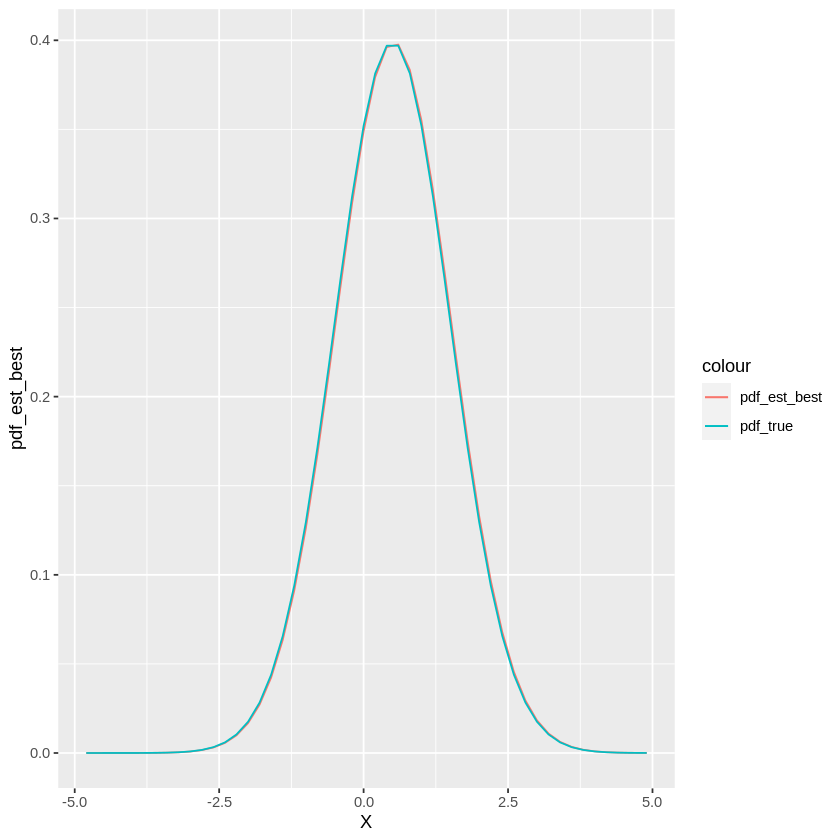

In [ ]:
# YOUR CODE (~1 line):
# based on the above AIC values, choose the best model among them
model_best = glm(Y ~ poly(X, degree = which.min(AIC), raw = TRUE) + offset(-X^2/2), family = poisson)

# YOUR CODE (~6 lines): use ggplot, compute and plot the estimated and true
# pdfs of Z, with the same requirements as before
pdf_est_best = predict(model_best, newdata = data.frame(X = X), type = "response")
total_area = sum(pdf_est_best * (X[2] - X[1]))
normalized_pdf_est = pdf_est_best / total_area

plot_data2 = data.frame(X = X, pdf_est_best = normalized_pdf_est, pdf_true = pdf_true(X))

ggplot(plot_data2, aes(x = X)) +
  geom_line(aes(y = pdf_est_best, color = "pdf_est_best")) +
  geom_line(aes(y = pdf_true, color = "pdf_true"))

In [ ]:
# install the glmnet package in R; this may take some time
# the glmnet documentation can be found at https://cran.r-project.org/web/packages/glmnet/glmnet.pdf

install.packages("glmnet")
library("glmnet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("glmnet"):
“installation of package ‘glmnet’ had non-zero exit status”


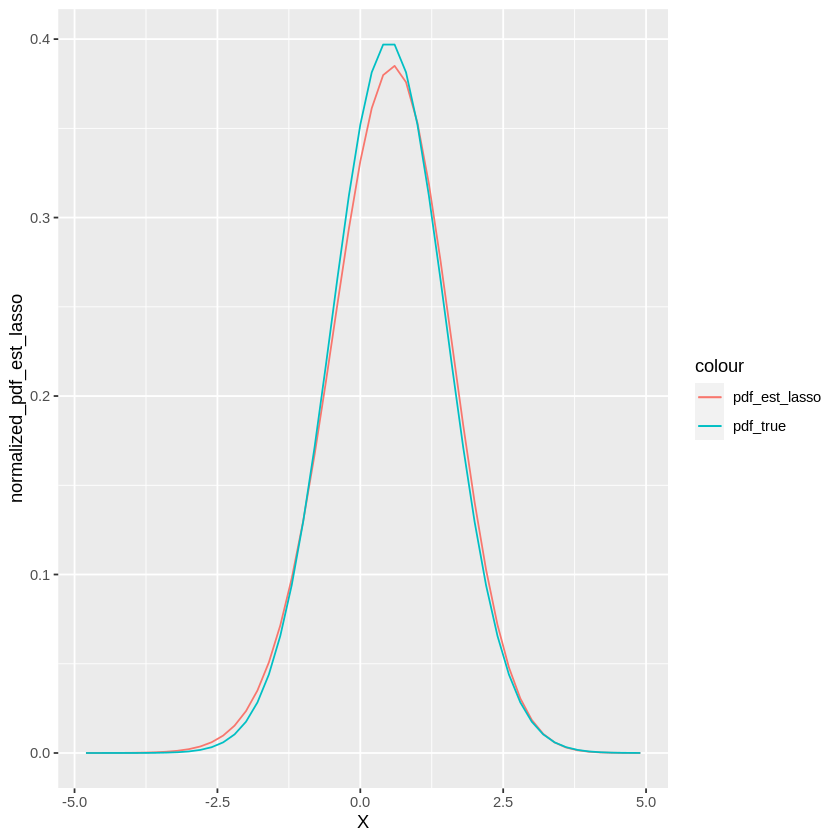

In [ ]:
# YOUR CODE (~2 lines):
# fit a Poisson GLM with a degree-5 polynomial of X, using Lasso and 10-fold cross validation
# output the coefficients of the fitted model
# note: look up cv.glmnet in the glmnet documentation

X_matrix = model.matrix(Y ~ poly(X, degree = 5, raw = TRUE) + offset(-X^2/2) - 1, data = hist_data)
fit_lasso = cv.glmnet(X_matrix, Y, family = "poisson", alpha = 1, nfolds = 10)

# YOUR CODE (~6 lines): as before, plot the estimated and true pdfs
X_matrix_plot = model.matrix(~ poly(X, degree = 5, raw = TRUE) - 1)
pdf_est_lasso = exp(predict(fit_lasso, newx = X_matrix_plot, s = "lambda.min"))
total_area = sum(pdf_est_lasso * (X[2] - X[1]))
normalized_pdf_est_lasso = pdf_est_lasso / total_area
plot_data3 = data.frame(X = X, pdf_est_lasso = normalized_pdf_est_lasso, pdf_true = pdf_true(X))

ggplot(plot_data3, aes(x = X)) +
  geom_line(aes(y = normalized_pdf_est_lasso, color = "pdf_est_lasso")) +
  geom_line(aes(y = pdf_true, color = "pdf_true"))

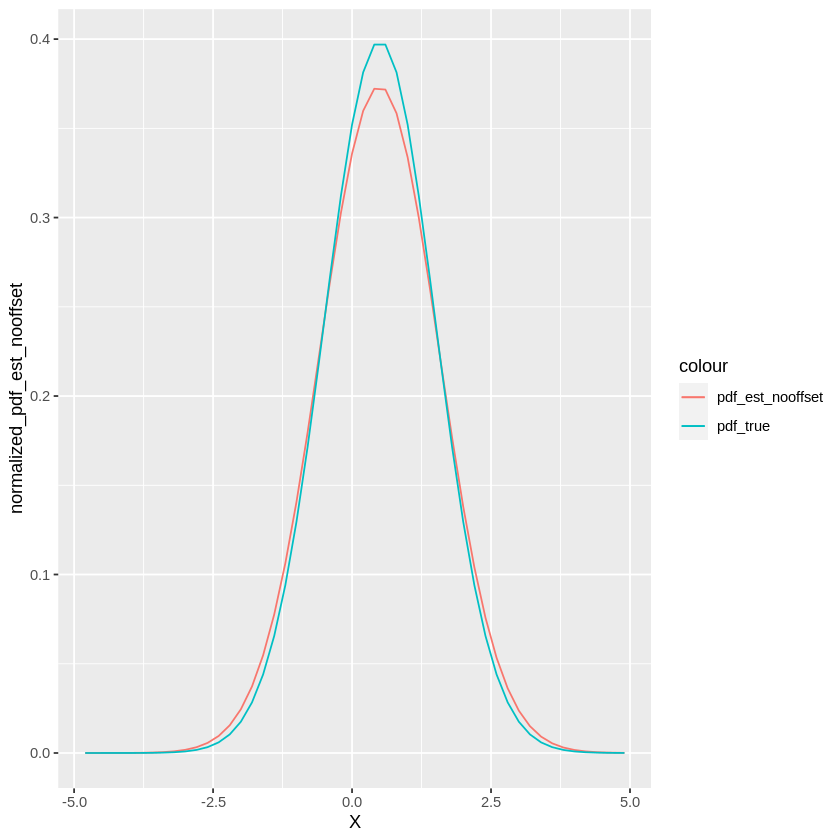

In [ ]:
# YOUR CODE (~2 lines):
# fit a Poisson GLM with a degree-5 polynomial of X, using Lasso and 10-fold cross validation
# KEY DIFFERENCE: use no offset in the new Lasso model
# output the coefficients of the fitted model

fit_lasso_nooffset = cv.glmnet(X_matrix, Y, family = "poisson", alpha = 1, nfolds = 10)

# YOUR CODE (~6 lines): as before, plot the estimated and true pdfs
pdf_est_nooffset = exp(predict(fit_lasso_nooffset, newx = X_matrix_plot, s = "lambda.min", type = "link"))
total_area = sum(pdf_est_nooffset * (X[2] - X[1]))
normalized_pdf_est_nooffset = pdf_est_nooffset / total_area

plot_data4 = data.frame(X = X, pdf_est_nooffset = normalized_pdf_est_nooffset, pdf_true = pdf_true(X))

ggplot(plot_data4, aes(x = X)) +
  geom_line(aes(y = normalized_pdf_est_nooffset, color = "pdf_est_nooffset")) +
  geom_line(aes(y = pdf_true, color = "pdf_true"))

In [ ]:
### code link
https://colab.research.google.com/drive/1D3WH-5vVzRYGMDux4EtfnRIaYwuk9zlm?usp=sharing